# 02 - Data from the Web

In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need! You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this brief tutorial to understand quickly how to use it.

# Imports

In [1]:
# Import libraries
import string
import re
import pickle
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

%matplotlib inline

# Constans definition

In [2]:
QS_RANKING_URL = 'https://www.topuniversities.com/university-rankings/world-university-rankings/2018'
QS_RANKING_JSON = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508104120137'

TIMES_RANKING_URL = 'http://timeshighereducation.com/world-university-rankings/2018/world-ranking'
TIMES_RANKING_JSON = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

In order to correctly match the two dataframes, we will use a single format for the naming scheme of the university. Since we (I) like most the Times format, we will use this latter website to search for QS entry and format them as Times proposes

In [3]:
#SEARCH_REFERENCE_URL = 'https://www.timeshighereducation.com/search?search='
SEARCH_REFERENCE_URL = 'https://www.topuniversities.com/search/site/'
#SEARCH_REFERENCE_URL = 'https://www.google.ch/search?q='

# General use functions definition

In [4]:
def build_html_parser(url):
    '''
    Function to build a parser object of type BeautifulSoup
    
    url      the webpage url to which send a get request to
    
    return   a parser of the given webpage
    '''
    
    r = requests.get(url)
    page_body = r.text
    
    soup = BeautifulSoup(page_body, 'html.parser')
    
    return soup

In [5]:
def clean_str_number(str_n):
    
    return str_n.strip('\n').strip('%').replace(',', '')

In [6]:
def search_standard_name(str_name):
    
    str_name = re.sub('\(.*?\)','', str_name) # no brackets
    str_name = str_name.replace(',', '')
    
    print(str_name)
    
    seach = build_html_parser(SEARCH_REFERENCE_URL + str_name.strip().replace(' ', '%20'))
    
    try:
        a = seach.find('div', class_='the-search-results').find('h1', class_='the-search-result__title').findAll('a')[0].text
    except:
        print('Not found :( -> {}'.format(str_name))
        a = str_name
    
    return (a)

### Task 1
Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018)

In [7]:
def parse_detail_page(url_detail):
    '''
    Function that parses the missing informations from the detail page of the university from the QS website
    
    Return   a dictionary with all the data found as integers values
    '''
    
    # Build a parser for the detail page
    soup = build_html_parser(url_detail)
    
    # Obtain and clean up the total faculty member value
    try:
        faculty_member_total = soup.find('div', class_='total faculty').find('div', class_='number').text
        faculty_member_total = clean_str_number(faculty_member_total)
    except:
        faculty_member_total = -1
    
    
    # Obtain and clean up the international faculty member value
    try:
        faculty_member_inter = soup.find('div', class_='inter faculty').find('div', class_='number').text.strip('\n')
        faculty_member_inter = clean_str_number(faculty_member_inter)
    except:
        faculty_member_inter = -1
    
    # Obtain and clean up the total students value
    try:
        student_total = soup.find('div', class_='total student').find('div', class_='number').text.strip('\n')
        student_total = clean_str_number(student_total)
    except:
        student_total = -1
    
    # Obtain and clean up the international students value
    try:
        student_inter = soup.find('div', class_='total inter').find('div', class_='number').text.strip('\n')
        student_inter = clean_str_number(student_inter)
    except:
        student_inter = -1
    
    # Build a dictionary for the parsed informations
    detail_info = {'Total faculty member' : int(faculty_member_total), 
                   'International faculty member' : int(faculty_member_inter), 
                   'Total student' : int(student_total), 
                   'International student' : int(student_inter)
                  }
    
    return detail_info

After some work on the Postman Inspector, we found out that the GET Request made to the QS website ended up with multiple attached files to go with the response. One of those files was a JSON with all the infos from the ranking.

In [8]:
req = requests.get(QS_RANKING_JSON)
data_from_url = req.json()

Such data is stored as a list of dictionaries, as visible in the example below:

In [9]:
print('First cell:')
print(data_from_url['data'][0], end='\n\n')

print('Second cell:')
print(data_from_url['data'][1], end='\n\n')

print('...')

First cell:
{'nid': '294850', 'url': '/universities/massachusetts-institute-technology-mit', 'title': 'Massachusetts Institute of Technology (MIT)', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">', 'core_id': '410', 'score': '100', 'rank_display': '1', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '6', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}

Second cell:
{'nid': '297282', 'url': '/universities/stanford-university', 'title': 'Stanford University', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/stanford-university_573_small_0.jpg" alt="Stanford University Logo">', 'core_id': '573', 'score': '98.7', 'rank_display': '2', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '5', 'guide': '<a h

In [10]:
def scrape_qs_ranking():
    '''
    Obtain the ranking from QS in a dataframe
    '''
    
    r = requests.get(QS_RANKING_JSON)
    data = r.json()
    
    university_list = []

    # Iterate throu the first 200 elments of the list
    for d in data['data'][:200]:
    
        # Store the parsed information into a dictionary
        info = {'Rank': d['rank_display'], 
                'University name': d['title'], 
                'Country': d['country'],
                'Region' : d['region']
               }
    
        # Extend the dictionary with the informations in the detail page
        url_detail = 'https://www.topuniversities.com' +  d['url']
        info.update( parse_detail_page( url_detail))
    
        university_list.append(info)
    
    
    qs_ranking_df = pd.DataFrame.from_dict(university_list)
    return qs_ranking_df

In [11]:
try:
    qs_ranking_df = pd.read_pickle('qs_save.p')
except (OSError, IOError) as e:
    qs_ranking_df = scrape_qs_ranking()
    qs_ranking_df.to_pickle('qs_save.p')
    
qs_ranking_df.head()

,Country,International faculty member,International student,Rank,Region,Total faculty member,Total student,University name
0,United States,1679,3717,1,North America,2982,11067,Massachusetts Institute of Technology (MIT)
1,United States,2042,3611,2,North America,4285,15878,Stanford University
2,United States,1311,5266,3,North America,4350,22429,Harvard University
3,United States,350,647,4,North America,953,2255,California Institute of Technology (Caltech)
4,United Kingdom,2278,6699,5,Europe,5490,18770,University of Cambridge


In [12]:
qs_ranking_df.set_index(['University name'], inplace=True)

We now calculate the two required ratios with the help of two auxiliary functions:

In [13]:
def compute_facutly_member_ratio(df):
    '''
    Co
    '''
    li = list()
    for i, row in df.iterrows():
        li.append(row['Total faculty member'] / row['Total student'])
    return li

In [14]:
def compute_student_ratio(df):
    li = list()
    for i, row in df.iterrows():
        li.append(row['International student'] / row['Total student'])
    return li

The computation results are stored in two new colums of the dataframe

In [15]:
qs_ranking_df['Faculty/students ratio'] = compute_facutly_member_ratio( qs_ranking_df )
qs_ranking_df['Intern/student ratio'] = compute_student_ratio( qs_ranking_df )

qs_ranking_df.head()

,Country,International faculty member,International student,Rank,Region,Total faculty member,Total student,Faculty/students ratio,Intern/student ratio
University name,,,,,,,,,
Massachusetts Institute of Technology (MIT),United States,1679,3717,1,North America,2982,11067,0.269450,0.335863
Stanford University,United States,2042,3611,2,North America,4285,15878,0.269870,0.227422
Harvard University,United States,1311,5266,3,North America,4350,22429,0.193945,0.234785
California Institute of Technology (Caltech),United States,350,647,4,North America,953,2255,0.422616,0.286918
University of Cambridge,United Kingdom,2278,6699,5,Europe,5490,18770,0.292488,0.356899


Plot of the dataframe for the ratios computed (double click on the plot for zoom)

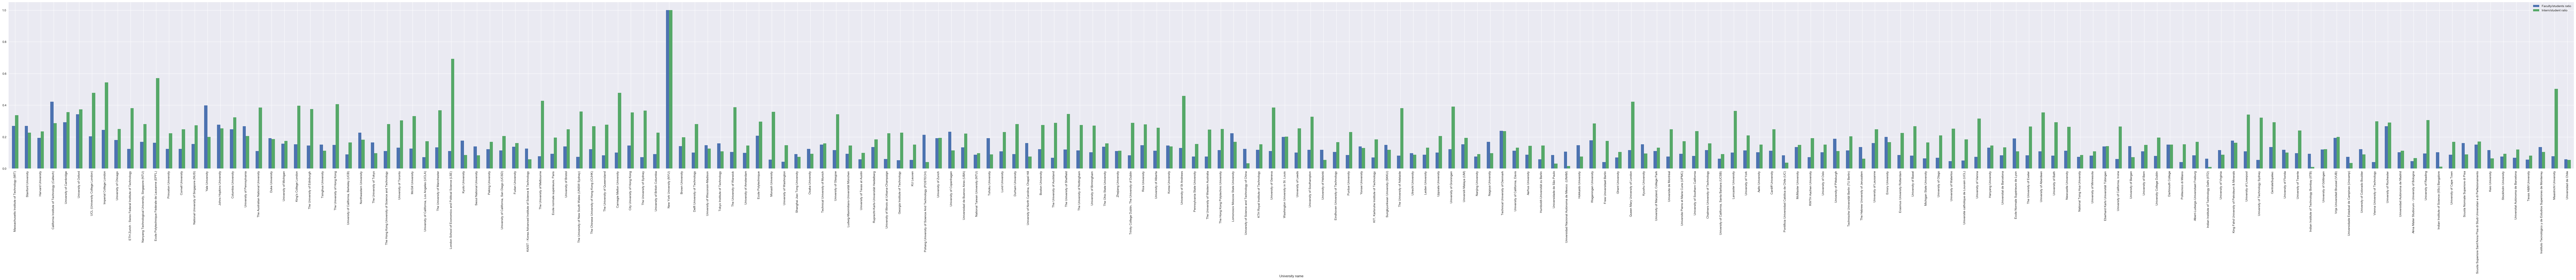

In [16]:
qs_ranking_df[['Faculty/students ratio', 'Intern/student ratio']].plot.bar( figsize=(150,10))

Plot the results aggregating by region:

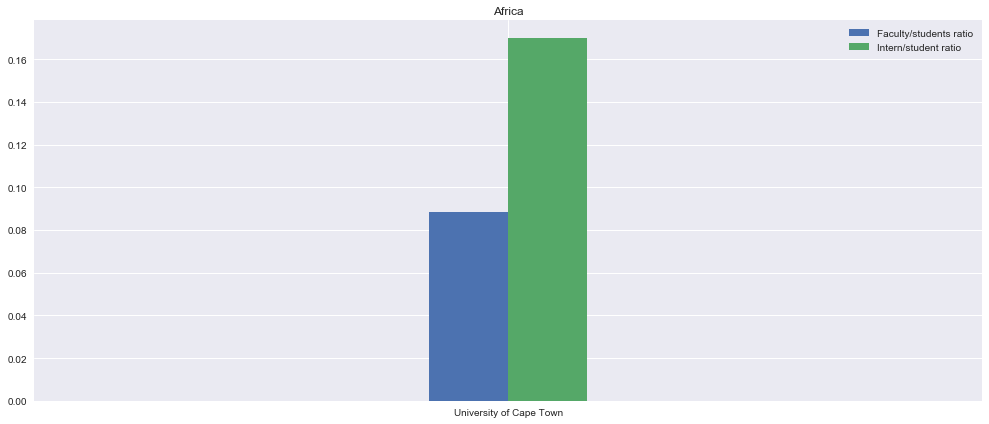

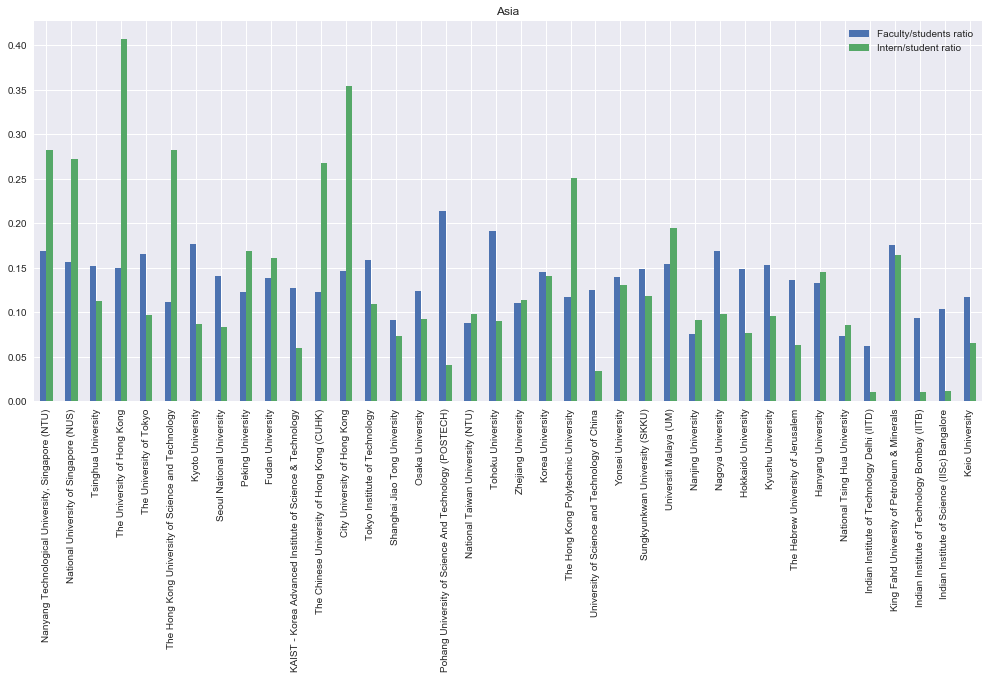

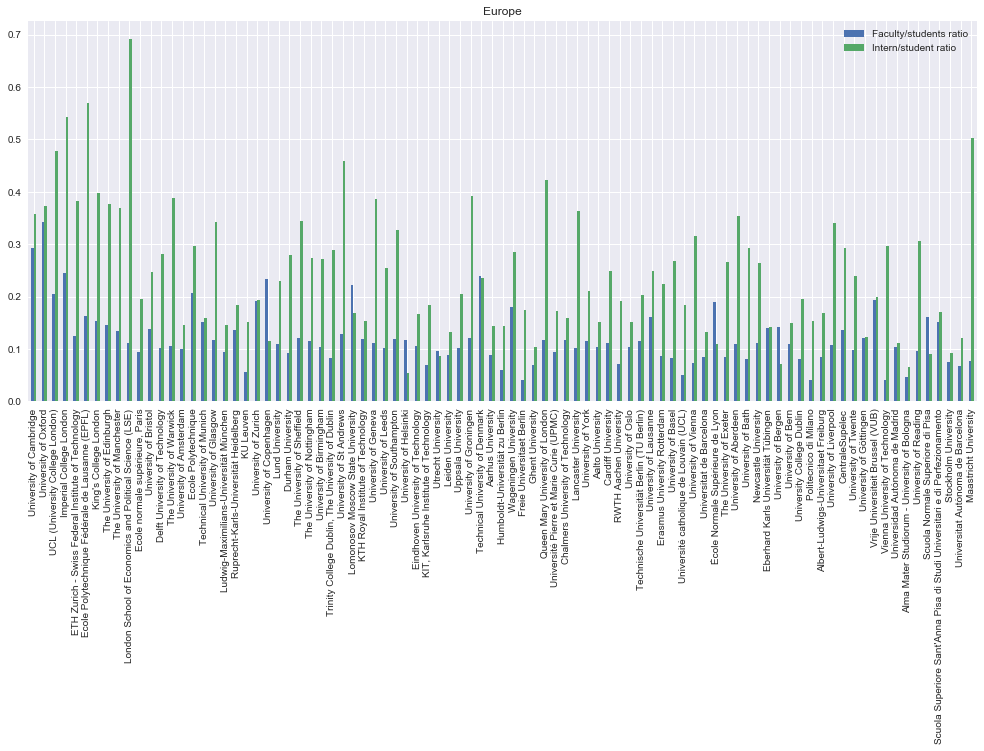

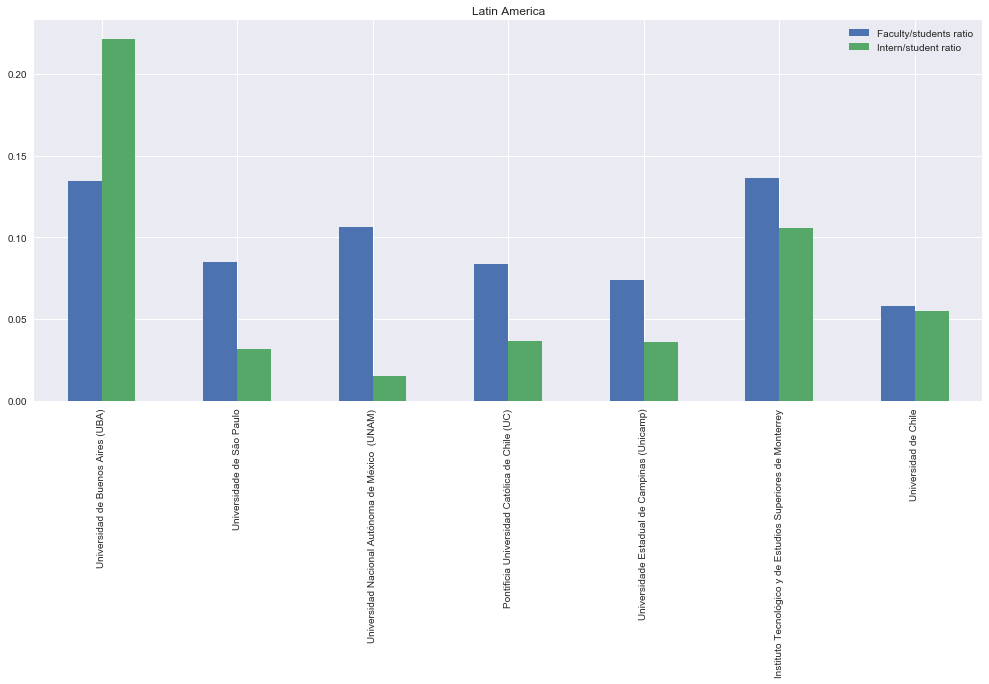

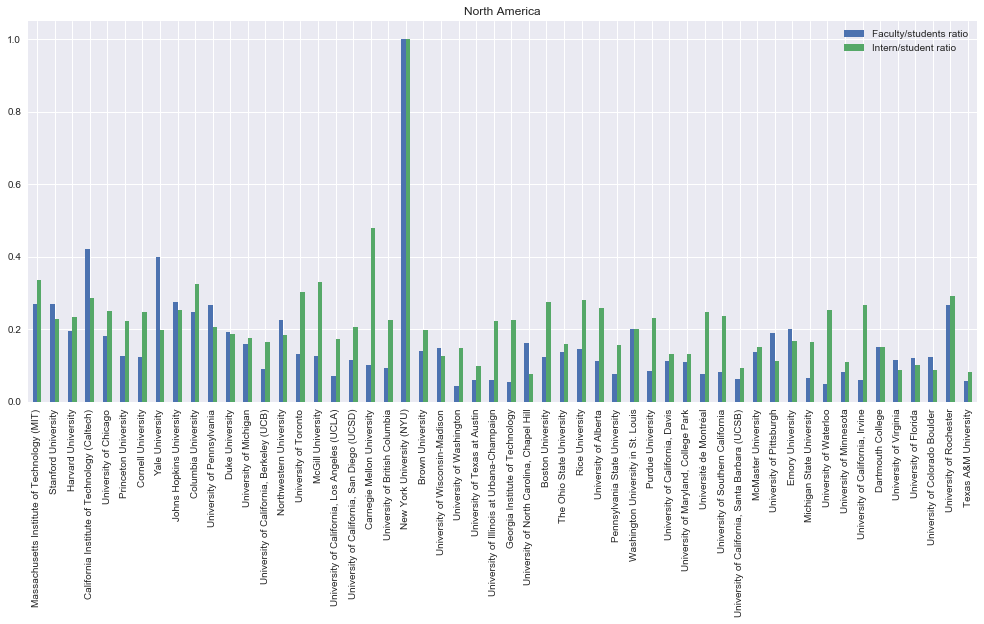

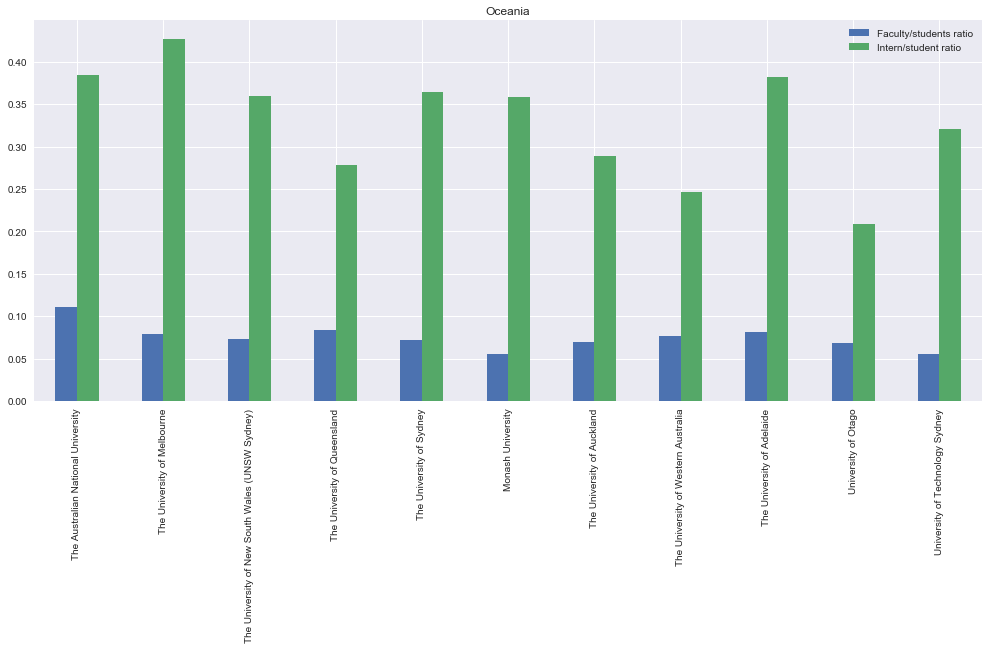

In [17]:
for i, (title, group) in enumerate(qs_ranking_df.groupby('Region')):
    ax = group[['Faculty/students ratio', 'Intern/student ratio']].plot.bar(figsize=(17, 7), 
                                                                            width= 0.5 if (len(group) > 2) else 0.1)
    plt.title(title)
    plt.xticks(rotation = 90 if (len(group) > 5) else 0)
    plt.xlabel("")
    plt.show()

Plot the results aggregating by country:

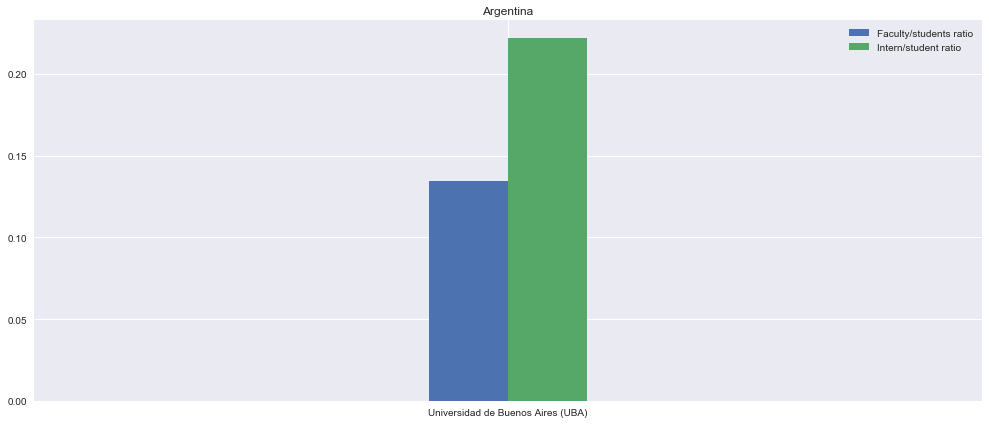

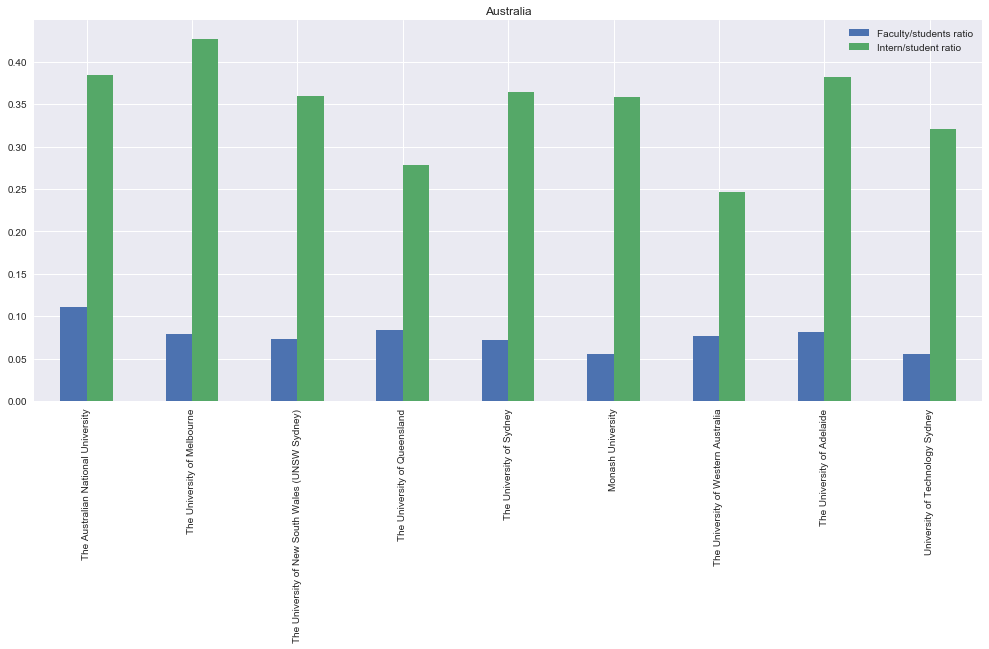

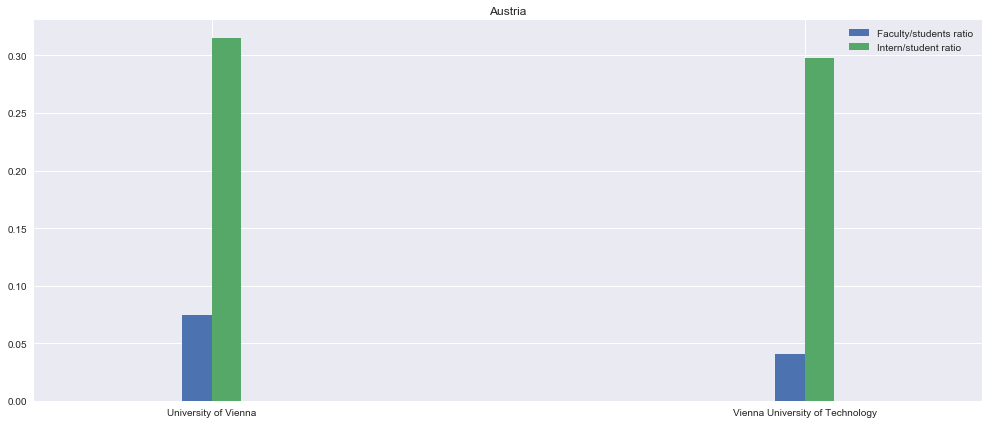

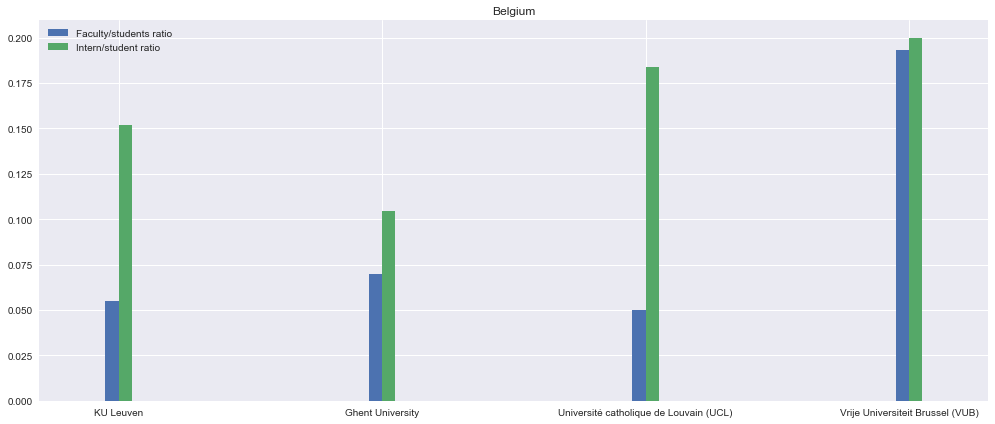

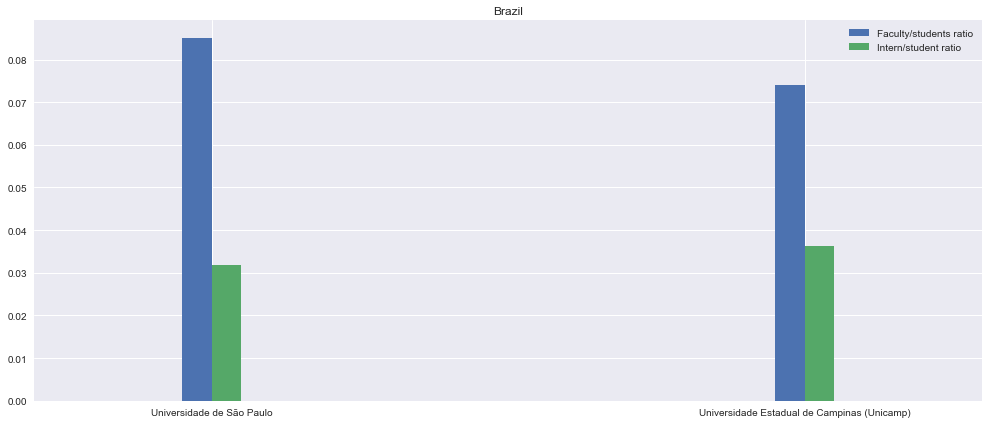

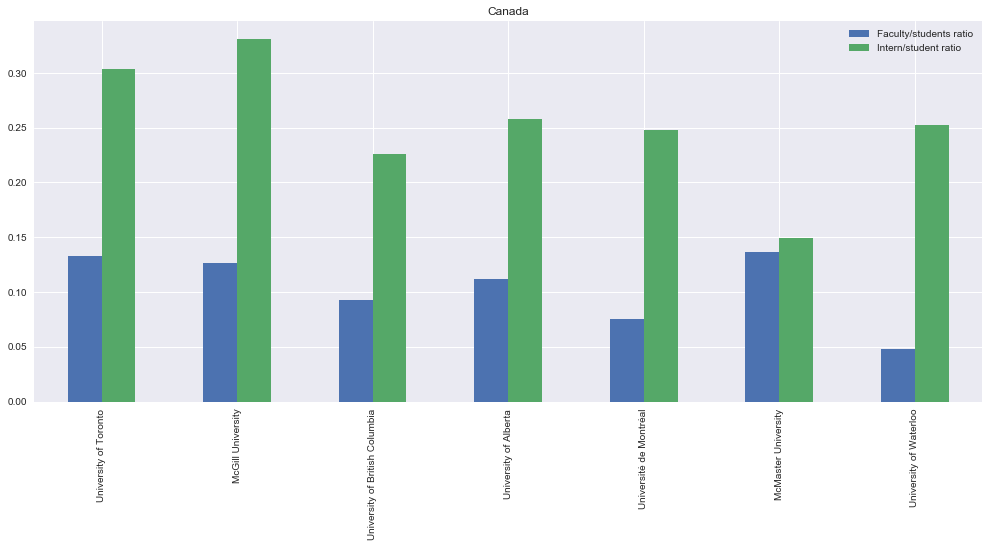

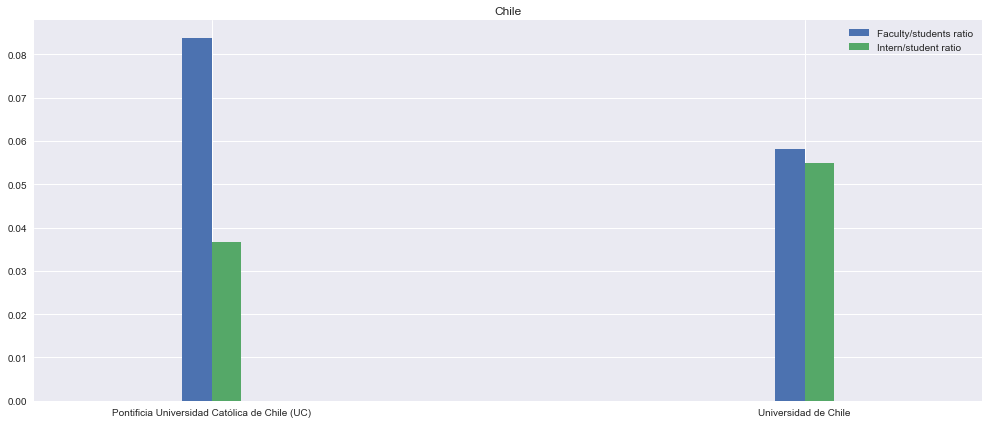

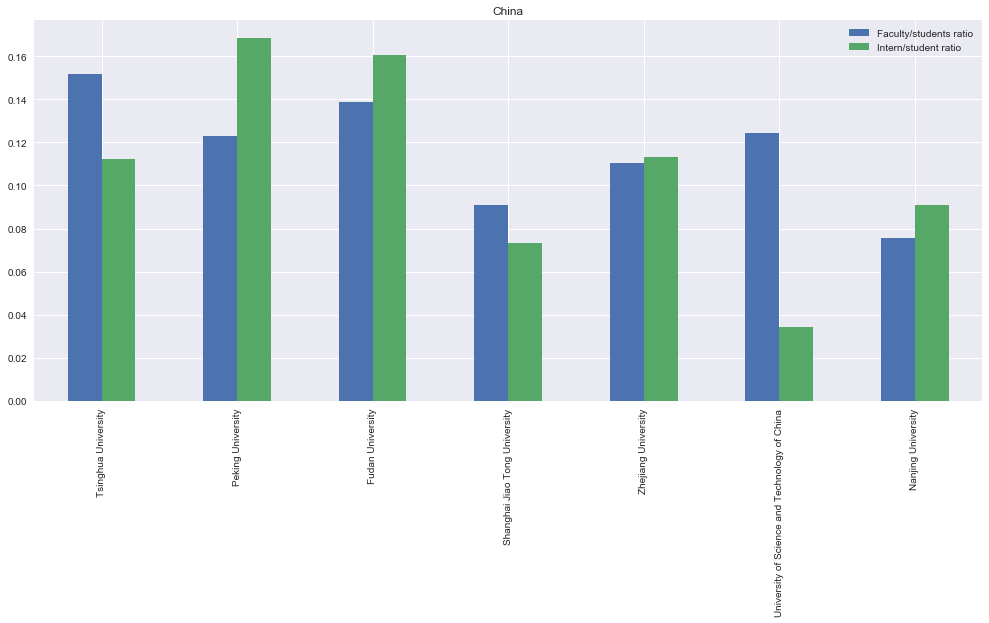

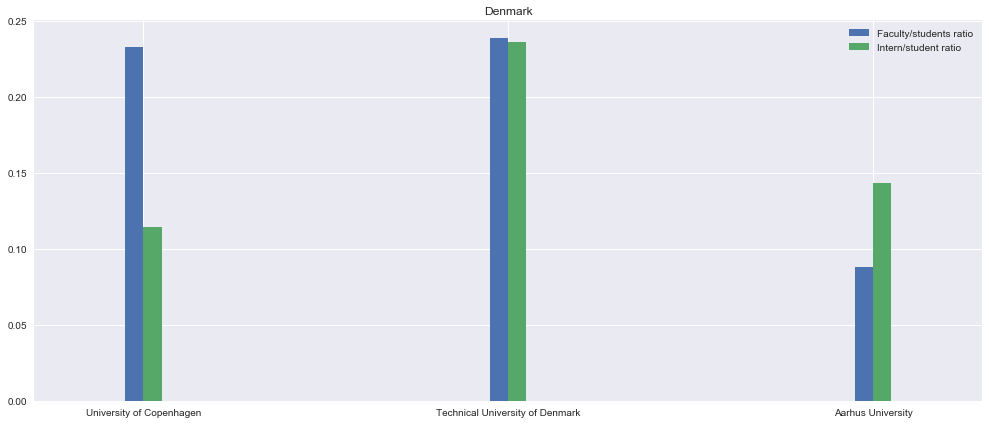

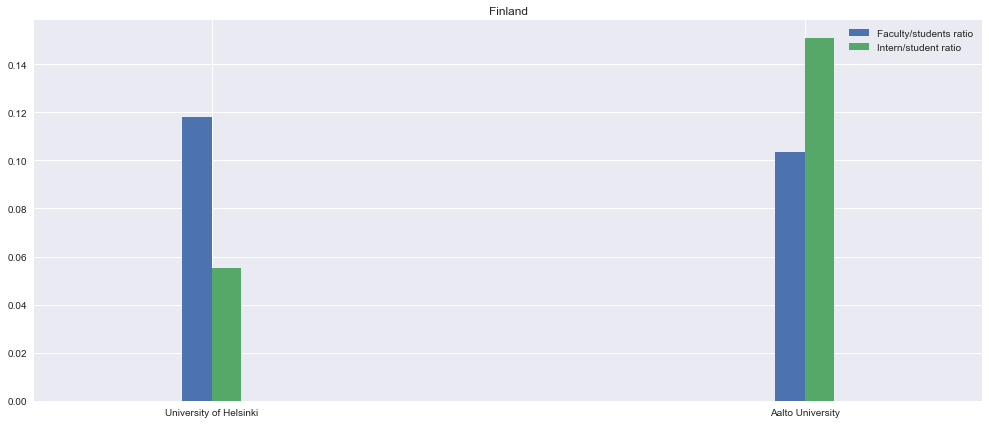

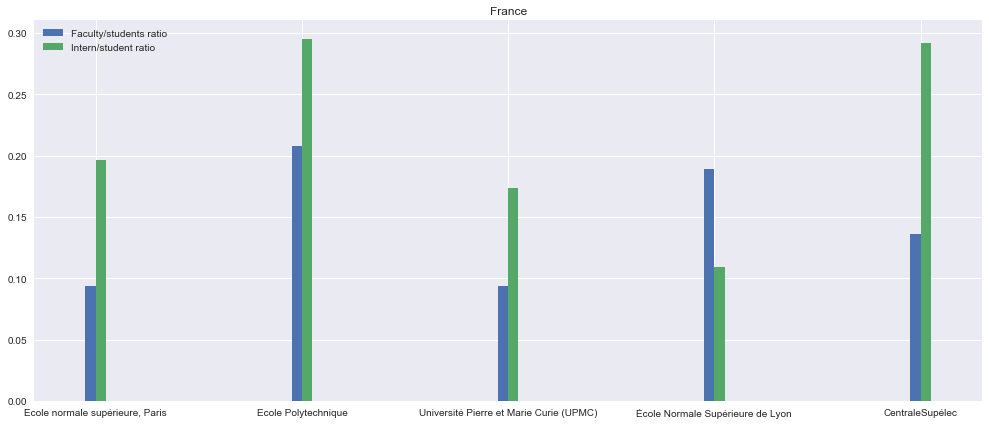

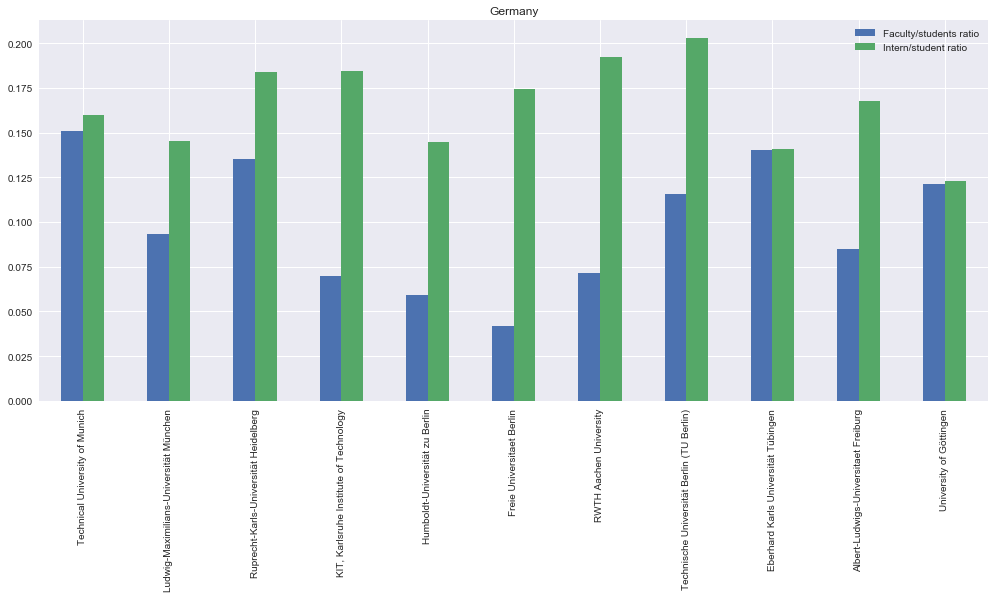

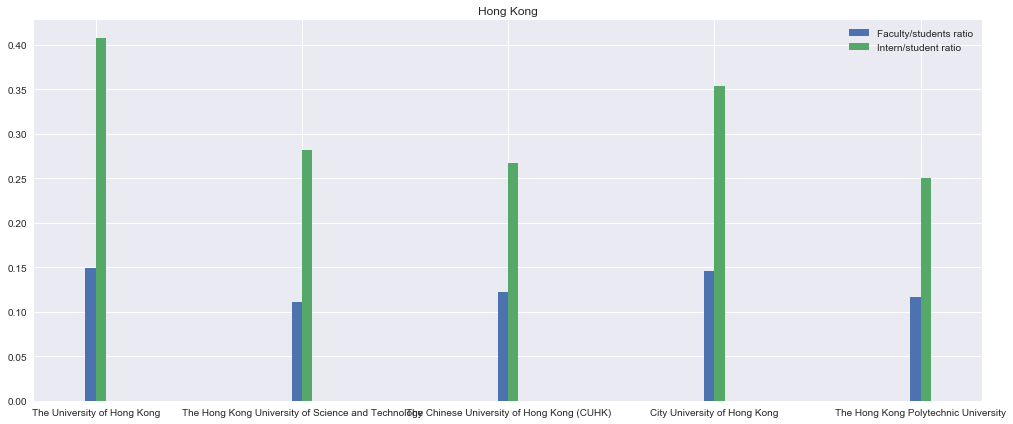

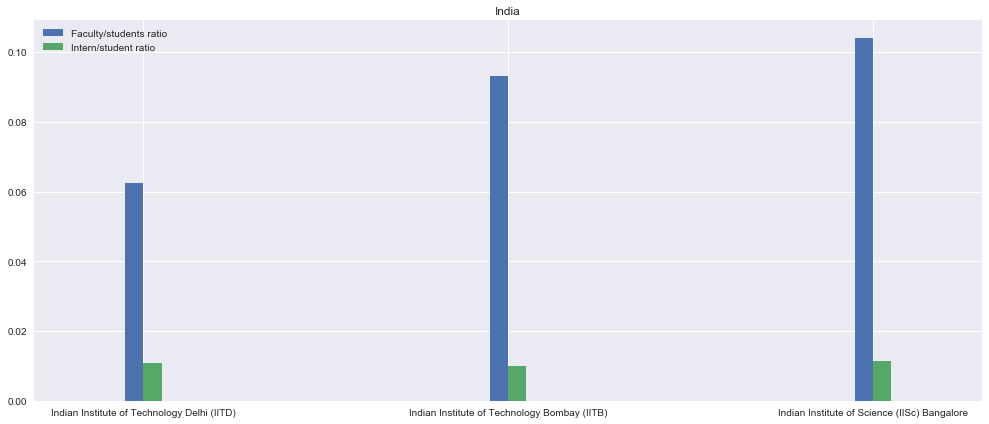

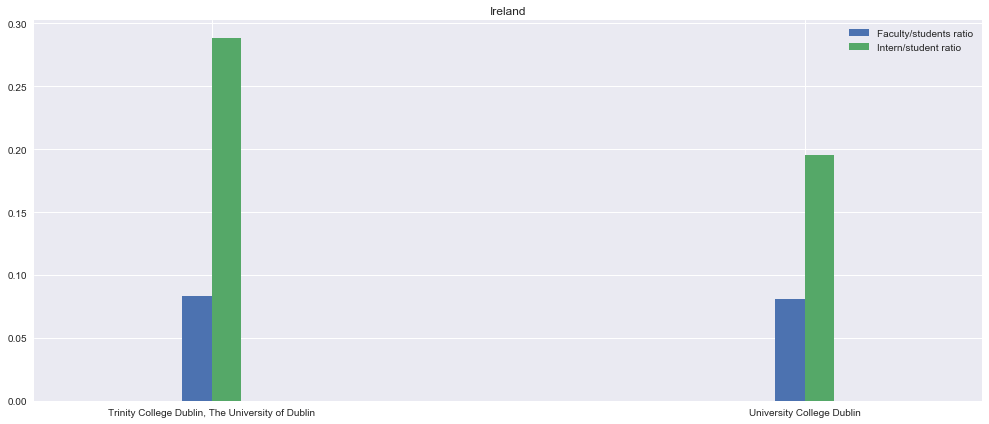

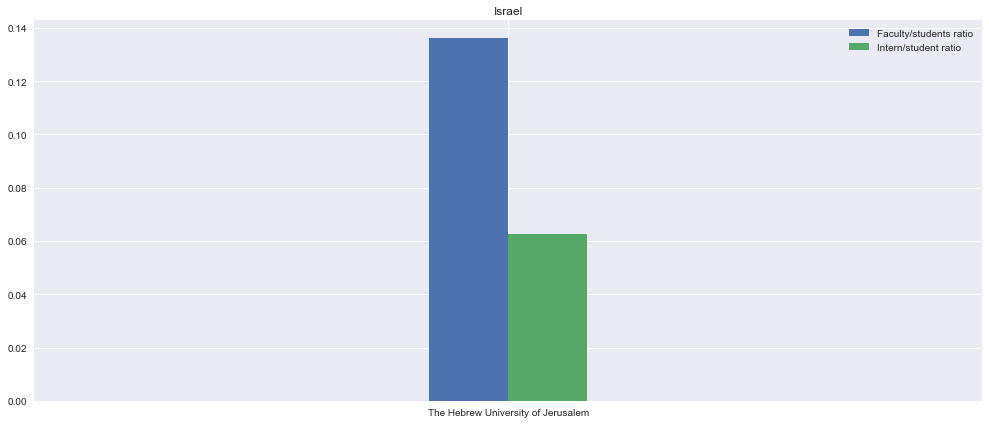

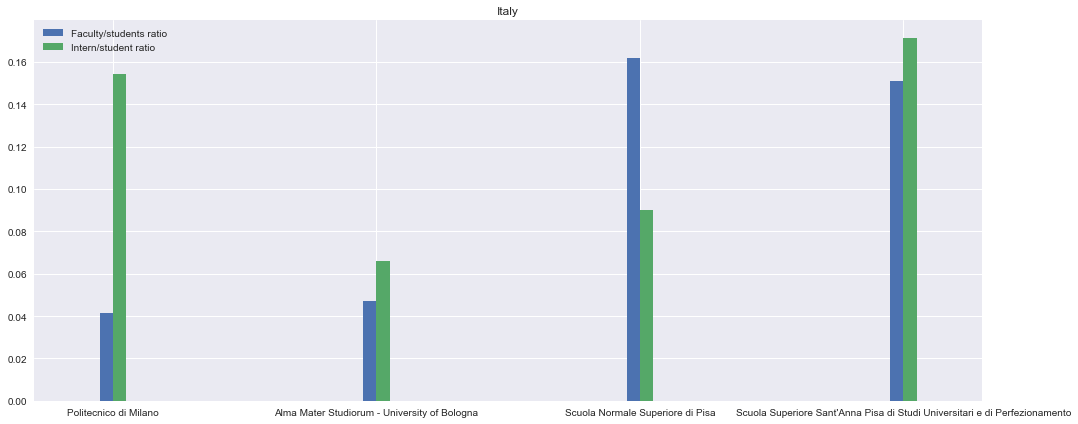

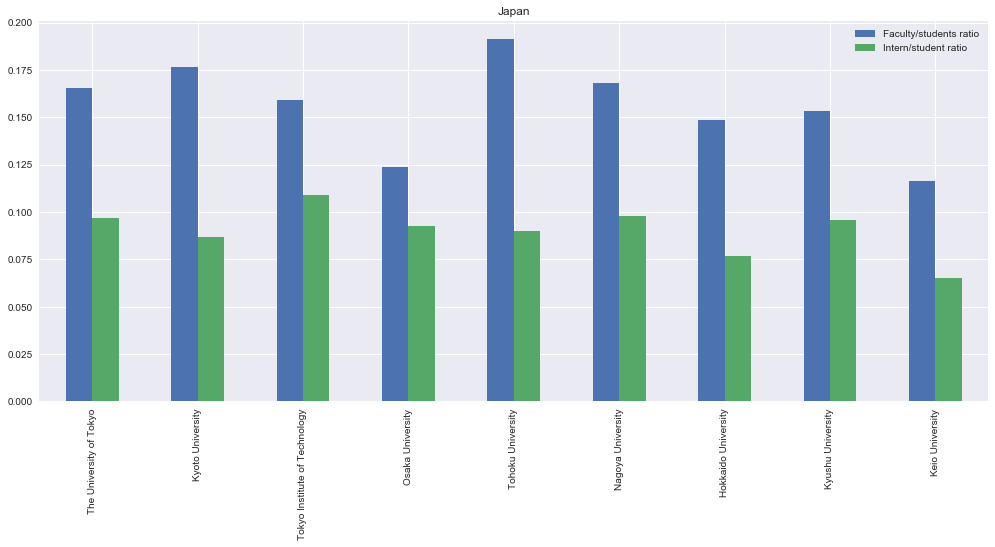

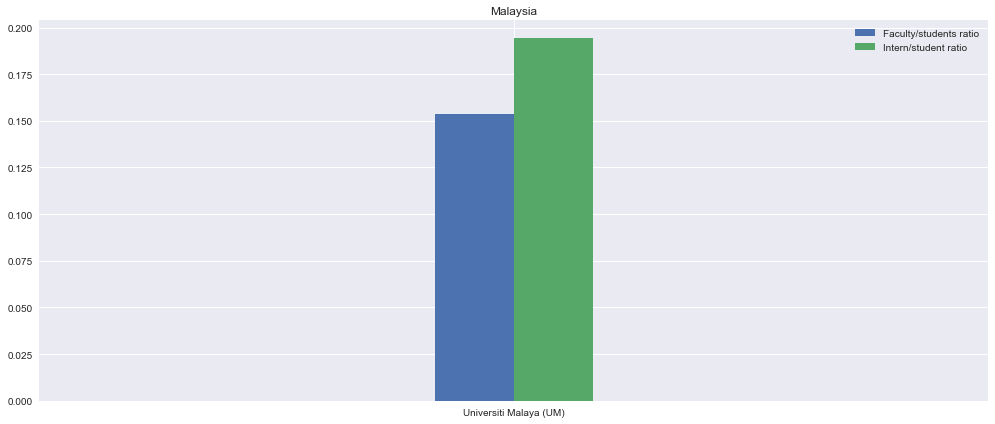

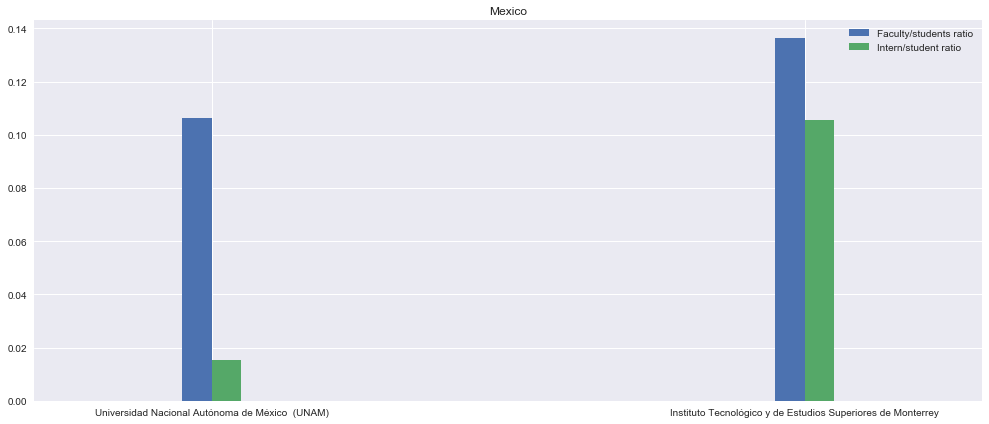

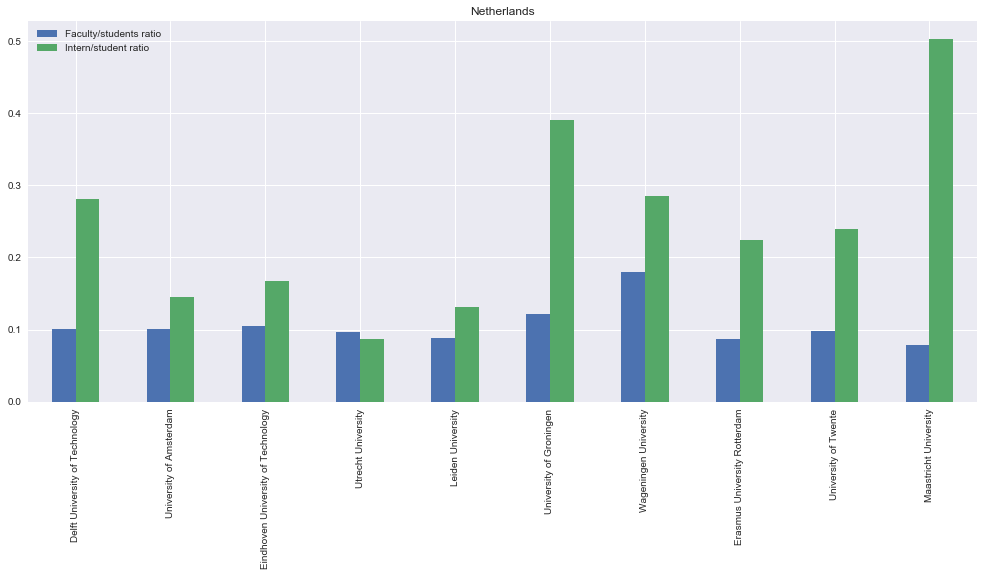

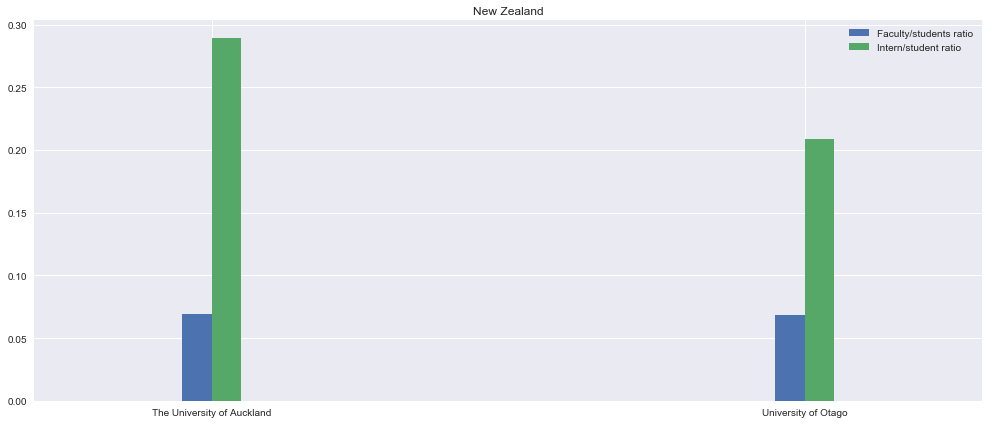

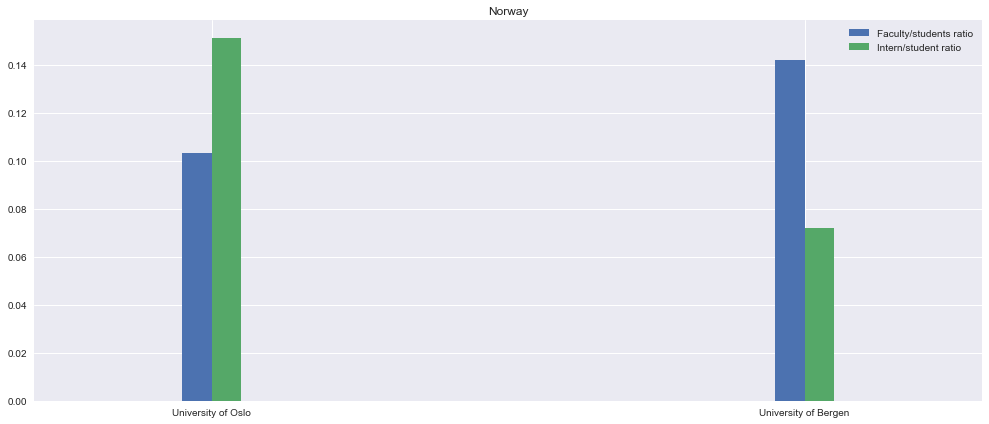

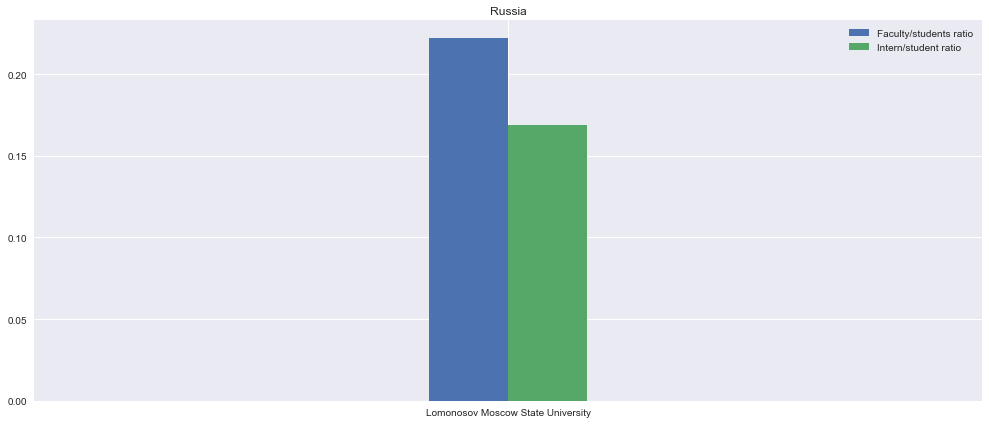

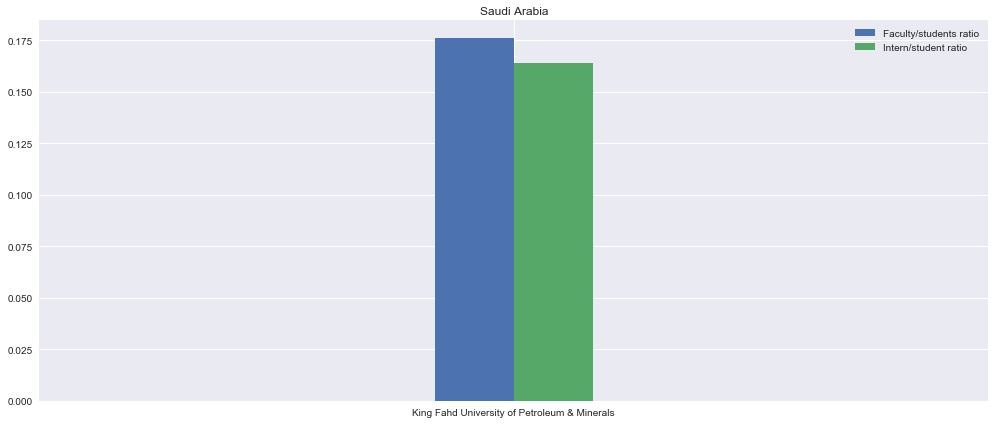

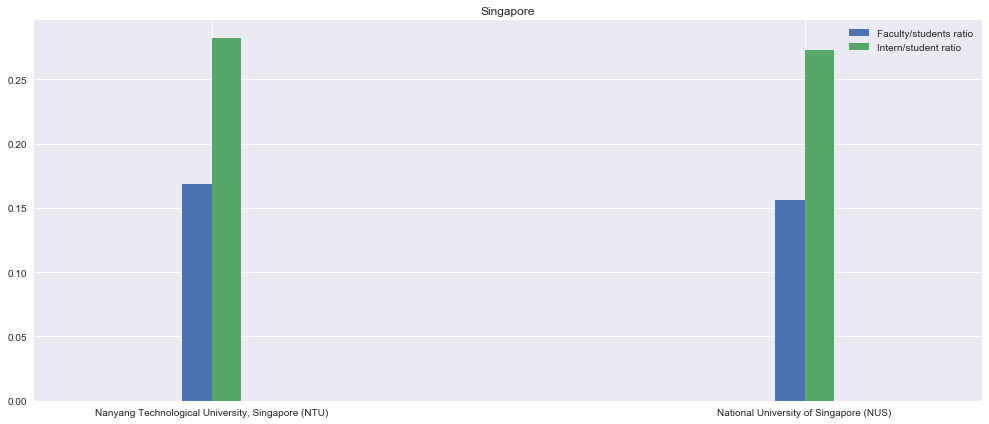

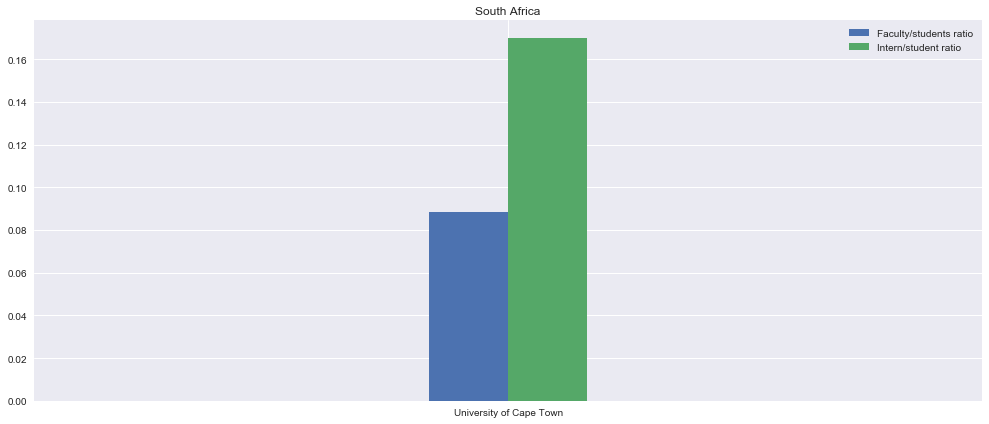

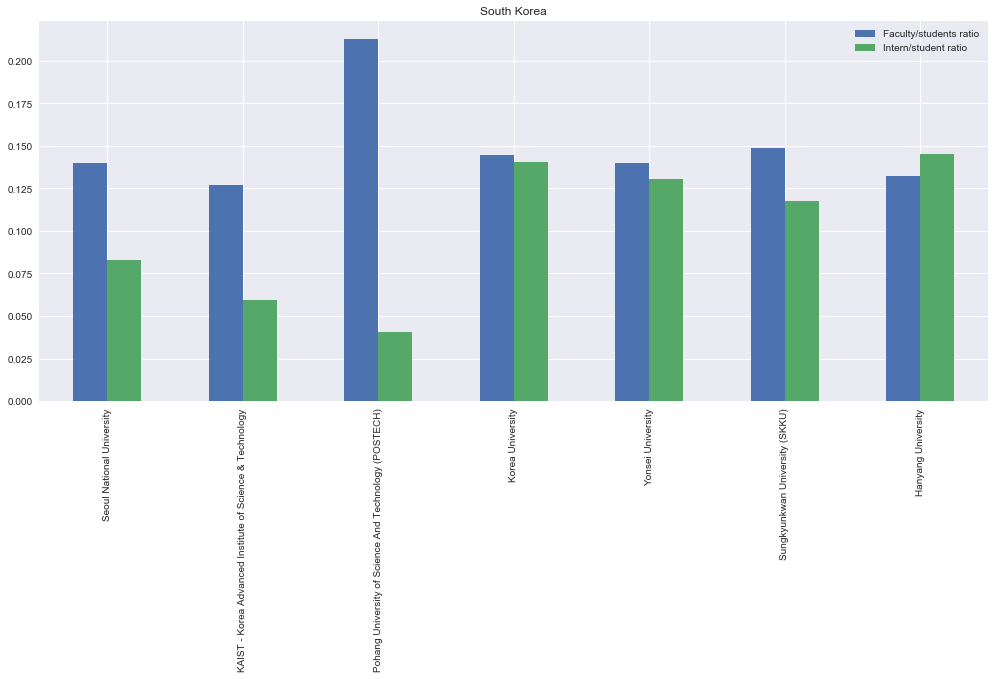

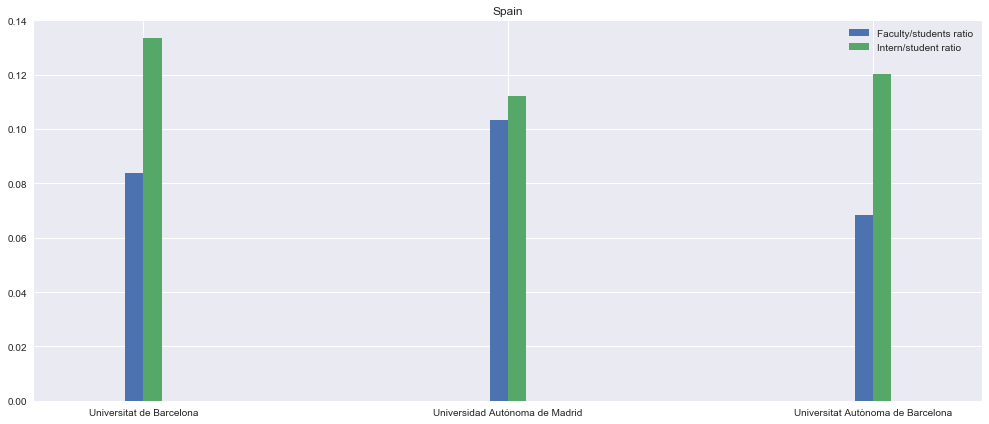

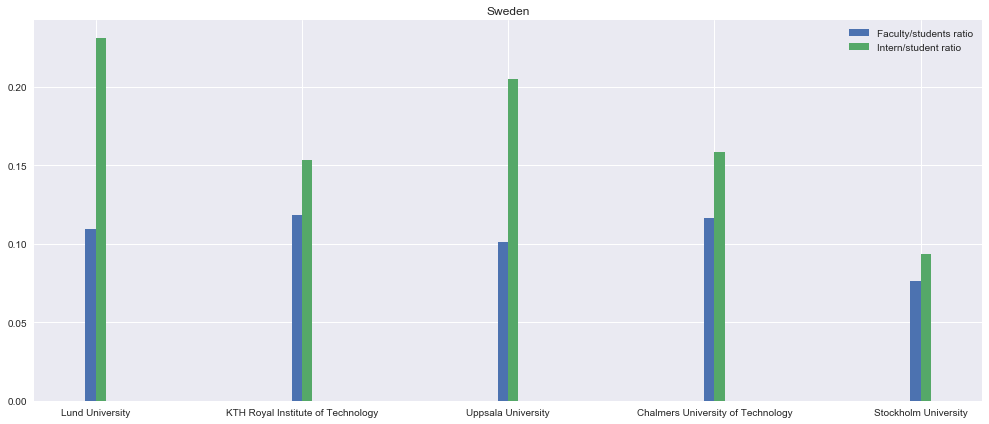

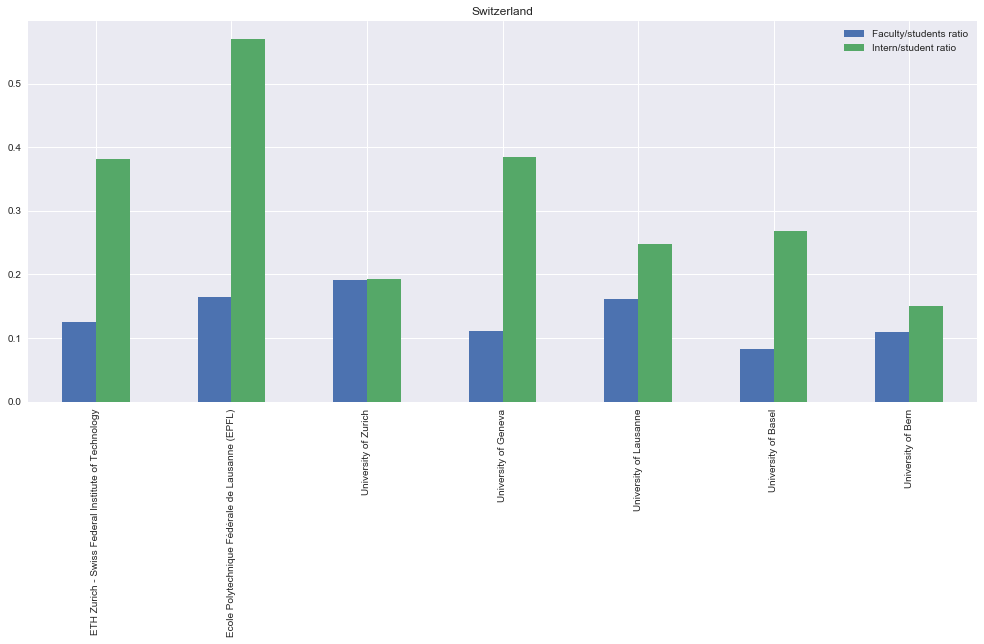

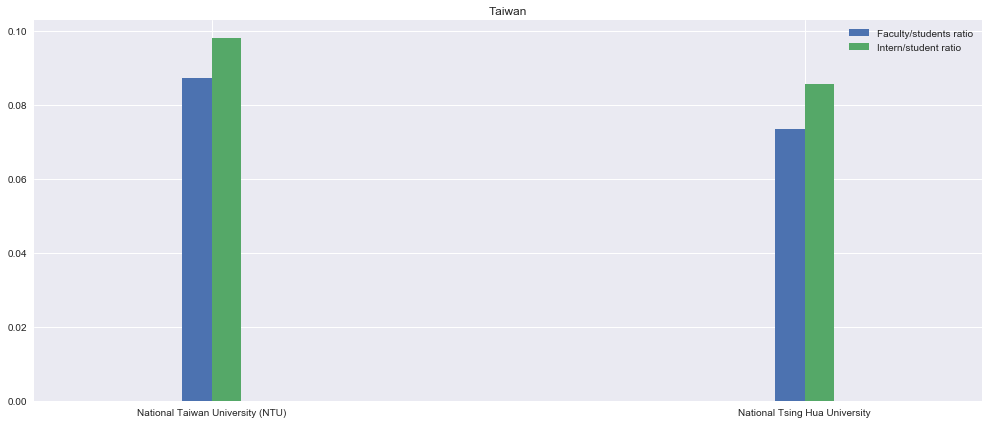

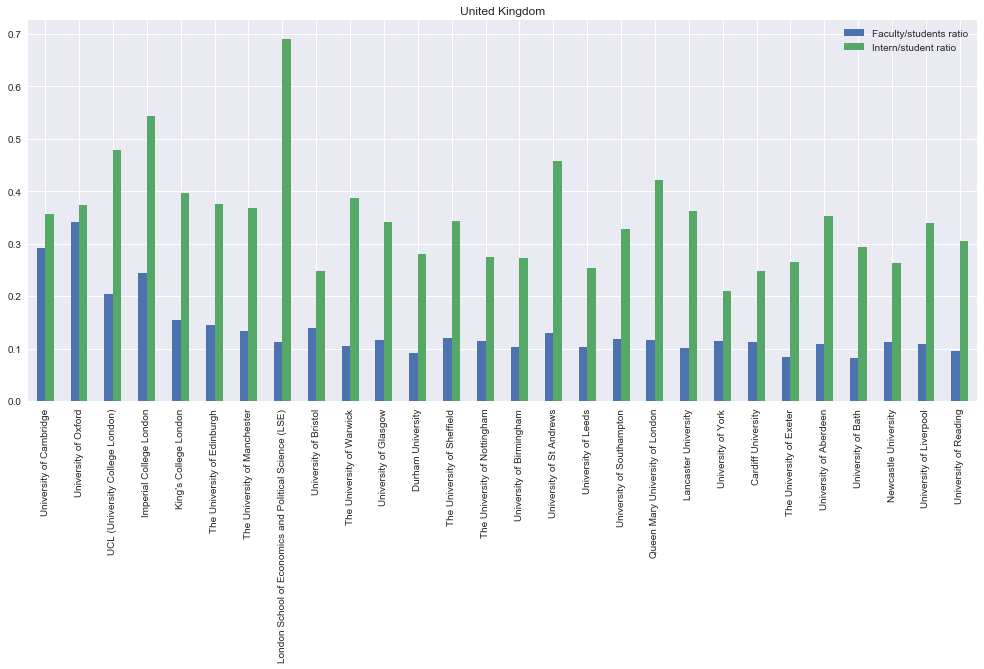

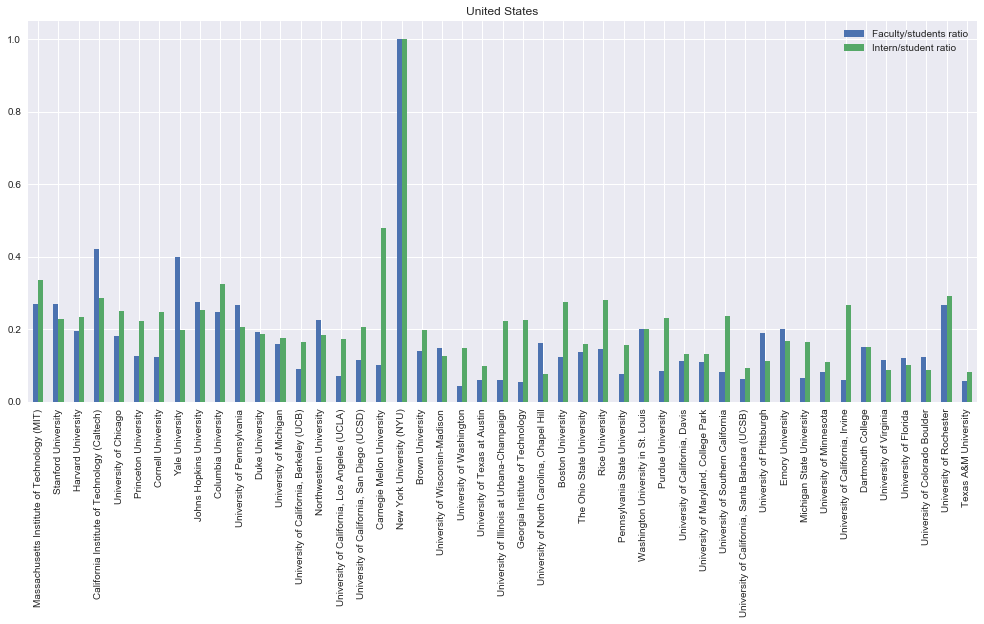

In [18]:
for i, (title, group) in enumerate(qs_ranking_df.groupby('Country')):
    ax = group[['Faculty/students ratio', 'Intern/student ratio']].plot.bar(figsize=(17, 7), 
                                                                            width= 0.5 if (len(group) > 5) else 0.1)
    plt.title(title)
    plt.xticks(rotation = 90 if (len(group) > 5) else 0)
    plt.xlabel("")
    plt.show()

### Task 2 - Scrape the Times ranking
Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

In [19]:
r = requests.get(TIMES_RANKING_JSON)
data = r.json()

In [20]:
def compute_value_from_percentage(total, percentage):
    
    total = int( total )
    percentage = float( percentage )
    
    return round( (total/100) * percentage )

In [21]:
def compute_value_from_proportion(total, proportion):
    
    total = int( total )
    proportion = float( proportion )
    
    return round( total / proportion )

In [22]:
university_list = []

# Iterate throu the first 200 elments of the list
for d in data['data'][:200]:
    
    # Preliminary computations to extract data
    intern_student = compute_value_from_percentage( clean_str_number( d['stats_number_students']), 
                                                   clean_str_number( d['stats_pc_intl_students'])
                                                  )
    
    faculty_member_total = compute_value_from_proportion( clean_str_number( d['stats_number_students']), 
                                                         clean_str_number( d['stats_student_staff_ratio'])
                                                        )
    
    # Store the parsed information into a dictionary
    info = {'Rank': d['rank'], 
            'University name': d['name'], 
            'Country': d['location'],
            'Total student' : int(clean_str_number( d['stats_number_students'])),
            'International student' : int(intern_student),
            'Total faculty member' : int(faculty_member_total)
           }
    
    university_list.append(info)
    
    
times_ranking_df = pd.DataFrame.from_dict(university_list)
times_ranking_df.head()

,Country,International student,Rank,Total faculty member,Total student,University name
0,United Kingdom,7755,1,1822,20409,University of Oxford
1,United Kingdom,6436,2,1687,18389,University of Cambridge
2,United States,596,=3,340,2209,California Institute of Technology
3,United States,3486,=3,2113,15845,Stanford University
4,United States,3800,5,1285,11177,Massachusetts Institute of Technology


In [23]:
times_ranking_df.set_index(['University name'], inplace=True)

In [24]:
#times_ranking_df['Faculty/students ratio'] = compute_facutly_member_ratio( qs_ranking_df )
times_ranking_df['Intern/student ratio'] = compute_student_ratio( times_ranking_df )

times_ranking_df.head()

,Country,International student,Rank,Total faculty member,Total student,Intern/student ratio
University name,,,,,,
University of Oxford,United Kingdom,7755,1,1822,20409,0.379979
University of Cambridge,United Kingdom,6436,2,1687,18389,0.349992
California Institute of Technology,United States,596,=3,340,2209,0.269805
Stanford University,United States,3486,=3,2113,15845,0.220006
Massachusetts Institute of Technology,United States,3800,5,1285,11177,0.339984


### Task 3 - Merge the dataframes
Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

In [25]:
qs_ranking_df['University name'] = qs_ranking_df.index
times_ranking_df['University name'] = times_ranking_df.index

In [26]:
qs_ranking_df['University name'] = qs_ranking_df['University name'].str.strip()
qs_ranking_df['Country'] = qs_ranking_df['Country'].str.strip()

times_ranking_df['University name'] = times_ranking_df['University name'].str.strip()
times_ranking_df['Country'] = times_ranking_df['Country'].str.strip()

Merging the two dataframes into one:

In [27]:
merged_ranking_df = pd.merge(qs_ranking_df, times_ranking_df, on=['University name', 'Country'])

merged_ranking_df

,Country,International faculty member,International student_x,Rank_x,Region,Total faculty member_x,Total student_x,Faculty/students ratio,Intern/student ratio_x,University name,International student_y,Rank_y,Total faculty member_y,Total student_y,Intern/student ratio_y
0,United States,2042,3611,2,North America,4285,15878,0.269870,0.227422,Stanford University,3486,=3,2113,15845,0.220006
1,United States,1311,5266,3,North America,4350,22429,0.193945,0.234785,Harvard University,5285,6,2284,20326,0.260012
2,United Kingdom,2278,6699,5,Europe,5490,18770,0.292488,0.356899,University of Cambridge,6436,2,1687,18389,0.349992
3,United Kingdom,2964,7353,6,Europe,6750,19720,0.342292,0.372870,University of Oxford,7755,1,1822,20409,0.379979
4,United Kingdom,2071,8746,8,Europe,3930,16090,0.244251,0.543567,Imperial College London,8721,8,1391,15857,0.549978
5,United States,635,3379,9,North America,2449,13557,0.180645,0.249244,University of Chicago,3381,9,2181,13525,0.249982
6,United States,246,1793,13,North America,1007,8069,0.124799,0.222208,Princeton University,1909,7,958,7955,0.239975
7,United States,970,5411,14,North America,2718,21904,0.124087,0.247033,Cornell University,5244,19,2230,21850,0.240000
8,United States,1708,2469,16,North America,4940,12402,0.398323,0.199081,Yale University,2553,12,2827,12155,0.210037
9,United States,1061,4105,17,North America,4462,16146,0.276353,0.254243,Johns Hopkins University,3720,13,3604,15498,0.240031
